# LiNGAM - Discovery of non-gaussian linear causal models

**Original article introducing LiNGAM**

S. Shimizu, P. O. Hoyer, A. Hyvärinen, and A. J. Kerminen. 
[A linear non-gaussian acyclic model for causal discovery](https://www.cs.helsinki.fi/group/neuroinf/lingam/JMLR06.pdf). 
Journal of Machine Learning Research, 7:2003-2030, 2006.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc
import statsmodels.api as sm
from statsmodels.formula.api import ols

from causalgraphicalmodels import StructuralCausalModel

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

In [2]:
columns = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5']

In [3]:
def total_causal_effects(result, X):
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)
    df = pd.DataFrame(causal_effects)
    labels = [f'x{i}' for i in range(X.shape[1])]
    df['from'] = df['from'].apply(lambda x : labels[x])
    df['to'] = df['to'].apply(lambda x : labels[x])
    return df

## Non-gaussian linear model

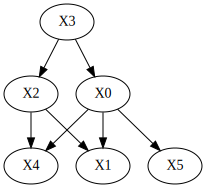

In [4]:
graph_G = StructuralCausalModel({
    "X3": lambda n_samples: np.random.uniform(size=n_samples),
    "X0": lambda X3, n_samples: 3.0 * X3 + np.random.uniform(size=n_samples),
    "X2": lambda X3, n_samples: 6.0 * X3 + np.random.uniform(size=n_samples),
    "X1": lambda X0, X2, n_samples: 3.0 * X0 + 2.0 * X2 + np.random.uniform(size=n_samples),
    "X5": lambda X0, n_samples: 4.0 * X0 + np.random.uniform(size=n_samples),
    "X4": lambda X0, X2, n_samples: 8.0 * X0 - 1.0 * X2 + np.random.uniform(size=n_samples)
})

graph_G.cgm.draw()

In [5]:
X = graph_G.sample(1000)
X = X[columns]

In [6]:
model = lingam.DirectLiNGAM()
model.fit(X)

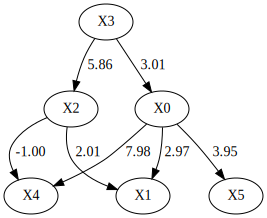

In [7]:
make_dot(model.adjacency_matrix_, labels=X.columns.to_list(), lower_limit=0.1)

In [8]:
p_values = model.get_error_independence_p_values(X)
print(p_values)

[[0.    0.539 0.309 0.941 0.792 0.629]
 [0.539 0.    0.172 0.398 0.251 0.515]
 [0.309 0.172 0.    0.    0.518 0.09 ]
 [0.941 0.398 0.    0.    0.43  0.   ]
 [0.792 0.251 0.518 0.43  0.    0.226]
 [0.629 0.515 0.09  0.    0.226 0.   ]]


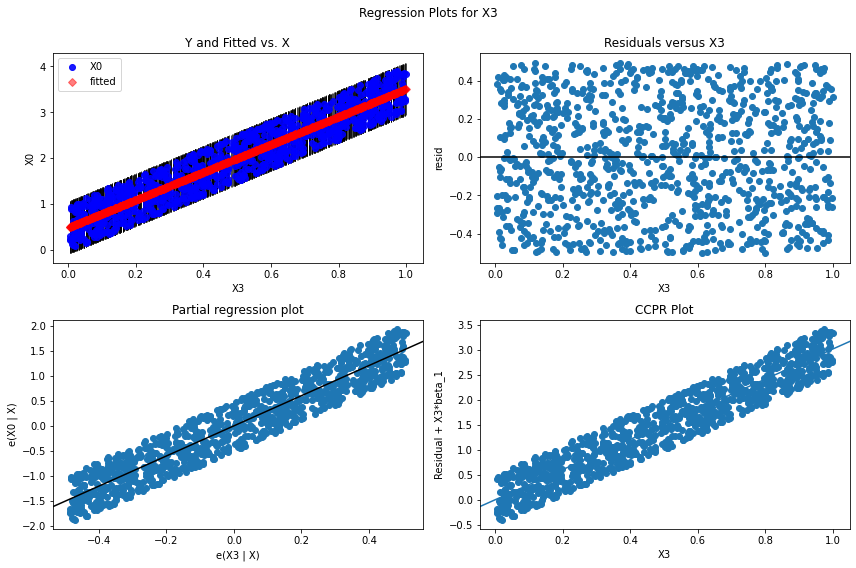

In [9]:
#fit simple linear regression model
lr = ols('X0 ~ X3', data=X).fit()

fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(lr, 'X3', fig=fig)

In [10]:
result = model.bootstrap(X, n_sampling=100)

In [11]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, 100)

DAG[0]: 82.0%
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x2 <--- x3 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)
DAG[1]: 8.0%
	x0 <--- x2 (b>0)
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x2 <--- x3 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)
DAG[2]: 6.0%
	x0 <--- x3 (b>0)
	x1 <--- x0 (b>0)
	x1 <--- x2 (b>0)
	x1 <--- x3 (b>0)
	x2 <--- x3 (b>0)
	x4 <--- x0 (b>0)
	x4 <--- x2 (b<0)
	x5 <--- x0 (b>0)


In [12]:
prob = result.get_probabilities(min_causal_effect=0.01)
print(prob)

[[0.   0.   0.09 1.   0.   0.  ]
 [1.   0.   1.   0.07 0.   0.  ]
 [0.03 0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [1.   0.   1.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.  ]]


In [13]:
total_causal_effects(result, X)

,from,to,effect,probability
0,x3,x0,3.014445,1.00
1,x0,x1,3.034570,1.00
2,x2,x1,2.111600,1.00
3,x3,x1,21.043123,1.00
4,x3,x2,6.029315,1.00
5,x0,x4,7.960071,1.00
6,x3,x4,18.057390,1.00
7,x0,x5,3.971226,1.00
8,x3,x5,12.091930,1.00
9,x2,x5,0.138213,0.79


## Gaussian linear model

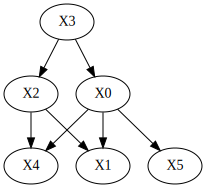

In [14]:
graph_G2 = StructuralCausalModel({
    "X3": lambda n_samples: np.random.normal(size=n_samples),
    "X0": lambda X3, n_samples: 3.0 * X3 + np.random.normal(size=n_samples),
    "X2": lambda X3, n_samples: 6.0 * X3 + np.random.normal(size=n_samples),
    "X1": lambda X0, X2, n_samples: 3.0 * X0 + 2.0 * X2 + np.random.normal(size=n_samples),
    "X5": lambda X0, n_samples: 4.0 * X0 + np.random.normal(size=n_samples),
    "X4": lambda X0, X2, n_samples: 8.0 * X0 - 1.0 * X2 + np.random.normal(size=n_samples)
})

graph_G2.cgm.draw()

In [15]:
X2 = graph_G2.sample(1000)
X2 = X2[columns]

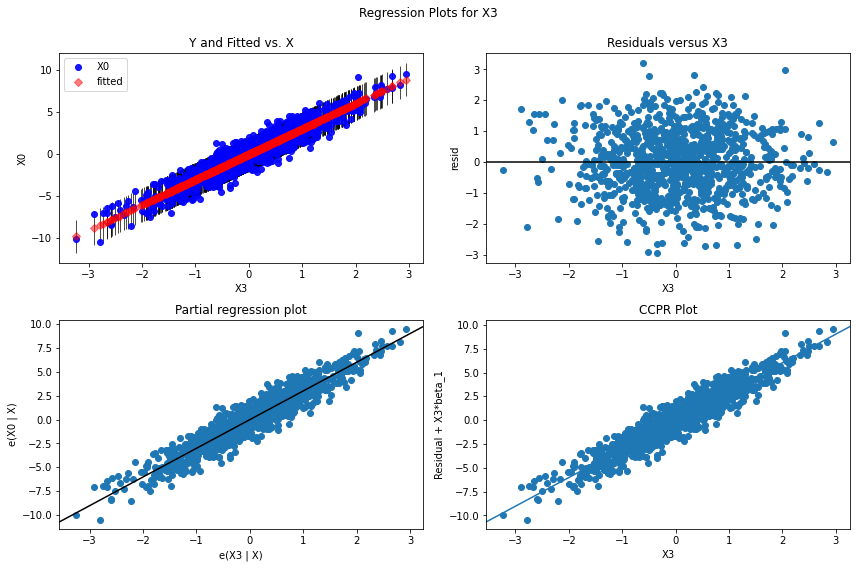

In [16]:
#fit simple linear regression model
model = ols('X0 ~ X3', data=X2).fit()

fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'X3', fig=fig)

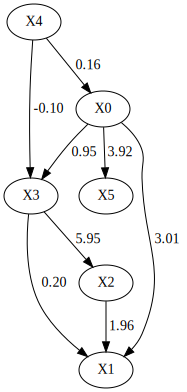

In [17]:
model = lingam.DirectLiNGAM()
model.fit(X2)
make_dot(model.adjacency_matrix_, labels=X2.columns.to_list(), lower_limit=0.1)

In [18]:
p_values = model.get_error_independence_p_values(X2)
print(p_values)

[[0.    0.142 0.    0.254 0.704 0.721]
 [0.142 0.    0.716 0.917 0.698 0.673]
 [0.    0.716 0.    0.    0.312 0.127]
 [0.254 0.917 0.    0.    0.623 0.858]
 [0.704 0.698 0.312 0.623 0.    0.   ]
 [0.721 0.673 0.127 0.858 0.    0.   ]]
